<a href="https://colab.research.google.com/github/nghoanglong/DS102-M11-CNCL/blob/main/Marketing_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libaries và Packages cần thiết

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date
%matplotlib inline

# Tiền xử lý dữ liệu - Hoàng Long

## Down and Save Dataset
**Lưu ý:** Nếu chưa down và save dataset, chạy các scripts dưới đây. Nếu đã từng chạy các scripts dưới đây, vui lòng bỏ qua và làm các bước tiếp theo

In [2]:
# Kết nối tới Drive để lưu dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DOWNLOAD_URL = 'https://raw.githubusercontent.com/nghoanglong/DS102-M11-CNCL/main/data/marketing_data.csv'
SAVING_PATH = '/content/drive/MyDrive/Colab Notebooks/HMTK/dataset' # đổi đường dẫn muốn lưu dataset ở đây

In [4]:
def fetch_data(download_url=DOWNLOAD_URL, saving_path=SAVING_PATH):
    os.makedirs(saving_path, exist_ok=True)
    tgz_path = os.path.join(saving_path, 'marketing_analytics.csv')
    urllib.request.urlretrieve(download_url, tgz_path)

In [5]:
fetch_data(DOWNLOAD_URL, SAVING_PATH)

## Load data
Đưa dữ liệu vào DataFrame

In [6]:
SAVING_PATH = '/content/drive/MyDrive/Colab Notebooks/HMTK/dataset' # thay đổi đường dẫn đến dataset ở đây
DATASET_PATH = os.path.join(SAVING_PATH, 'marketing_analytics.csv')

In [7]:
df = pd.read_csv(DATASET_PATH)

In [8]:
# kiểm tra dữ liệu với 5 dòng đầu
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP


In [13]:
# Xem thông tin về dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

## Rename Attributes and Cast Type
Ở bước này, ta nhận thấy có một số vấn đề sau với dữ liệu:

*   Tên của các cột chưa được chuẩn hóa (Sai và gây khó hiểu)
*   Kiểu dữ liệu của các cột chưa được tốt

Ta tiến hành đổi tên các cột, và chuyển đổi kiểu dữ liệu như sau



In [9]:
# Rename columns
df.rename(columns={'ID':'User_ID'}, inplace=True)
df.rename(columns={' Income ':'Income'}, inplace=True)
df.rename(columns={'Dt_Customer': 'Date_Enroll'}, inplace = True)
df.rename(columns={'MntMeatProducts': 'MntMeats'}, inplace = True)
df.rename(columns={'MntFishProducts': 'MntFishs'}, inplace = True)
df.rename(columns={'MntSweetProducts': 'MntSweets'}, inplace = True)
df.rename(columns={'MntGoldProds': 'MntGolds'}, inplace = True)

In [10]:
# Cast type to numertical
df['Income'] = df['Income'].str.replace('$', '')
df['Income'] = df['Income'].str.replace(',', '').astype('float')

# Cast type to datetime
df['Date_Enroll'] = pd.to_datetime(df['Date_Enroll'])

In [11]:
# Kết quả
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   User_ID              2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Date_Enroll          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeats             2240 non-null   int64         
 12  MntFishs             2240 non-null   int64         
 13  MntSweets            2240 non-nul

## Explory Data Analysis
Phân tích dữ liệu, đưa ra góc nhìn tổng quan về dữ liệu

In [12]:
# Tổng quan thông số dữ liệu
df.describe()

,User_ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeats,MntFishs,MntSweets,MntGolds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.149107,0.009375
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.356274,0.096391
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Xử lý Outliers của các cột dạng Numeric

In [13]:
# Lấy ra những cột dạng numeric trong data
numeric = df.select_dtypes(exclude='object')

In [14]:
def report(feature):
    """Hàm hỗ trợ visualize outliner
    """
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(16,4)
    fig.suptitle(feature, fontsize=16)
    sns.histplot(data=numeric, x=feature, kde=True, ax=ax[0])
    sns.boxplot(data=numeric, x=feature, ax=ax[1])
    plt.show()

    print(numeric[feature].describe())

In [15]:
numeric.columns

Index(['User_ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Date_Enroll',
       'Recency', 'MntWines', 'MntFruits', 'MntMeats', 'MntFishs', 'MntSweets',
       'MntGolds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain'],
      dtype='object')

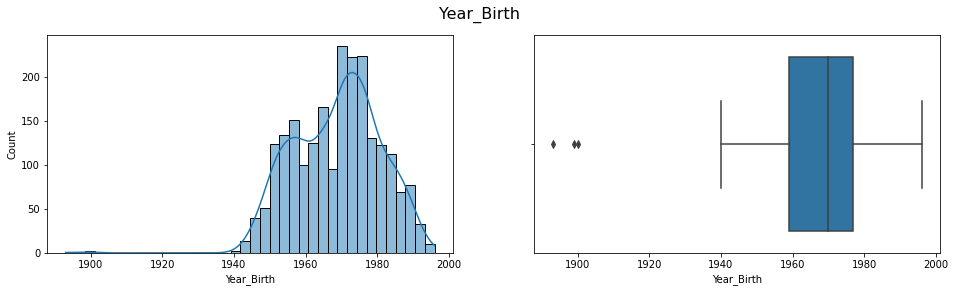

count    2240.000000
mean     1968.805804
std        11.984069
min      1893.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64


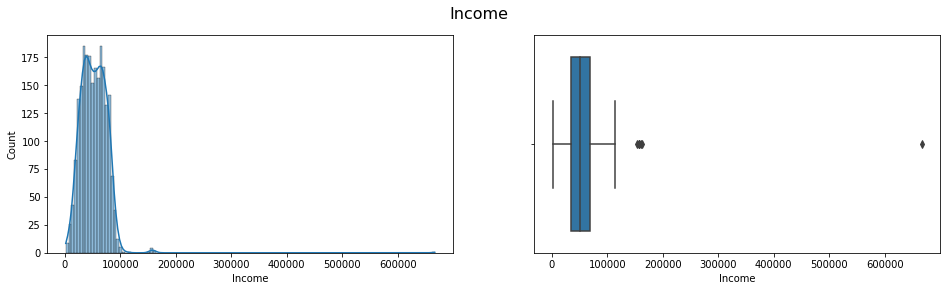

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64


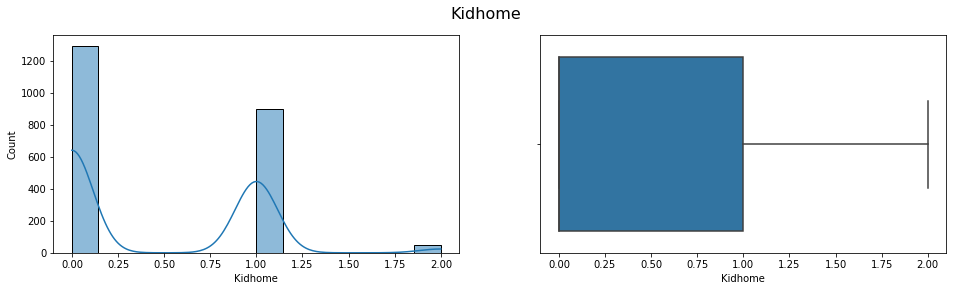

count    2240.000000
mean        0.444196
std         0.538398
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Kidhome, dtype: float64


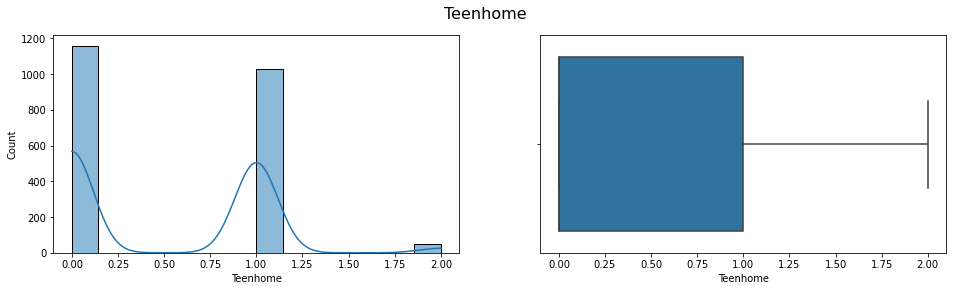

count    2240.000000
mean        0.506250
std         0.544538
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Teenhome, dtype: float64


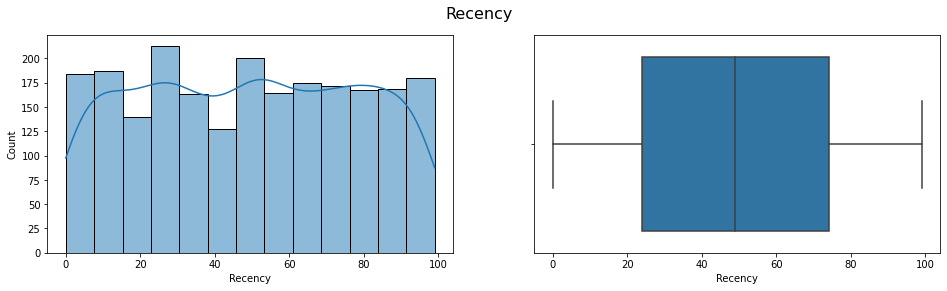

count    2240.000000
mean       49.109375
std        28.962453
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Recency, dtype: float64


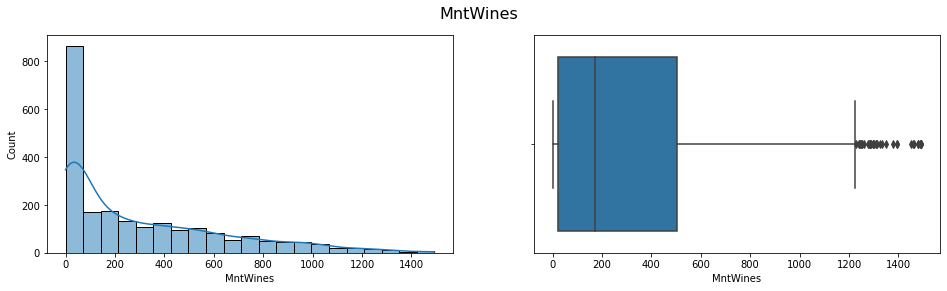

count    2240.000000
mean      303.935714
std       336.597393
min         0.000000
25%        23.750000
50%       173.500000
75%       504.250000
max      1493.000000
Name: MntWines, dtype: float64


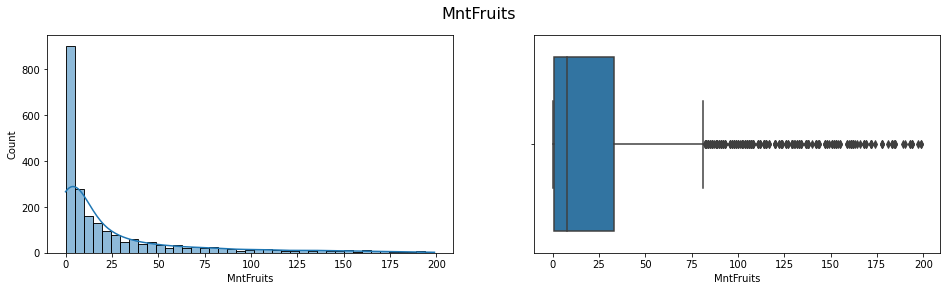

count    2240.000000
mean       26.302232
std        39.773434
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       199.000000
Name: MntFruits, dtype: float64


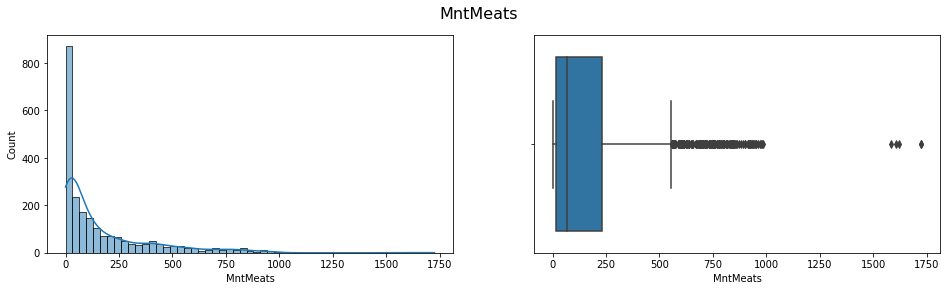

count    2240.000000
mean      166.950000
std       225.715373
min         0.000000
25%        16.000000
50%        67.000000
75%       232.000000
max      1725.000000
Name: MntMeats, dtype: float64


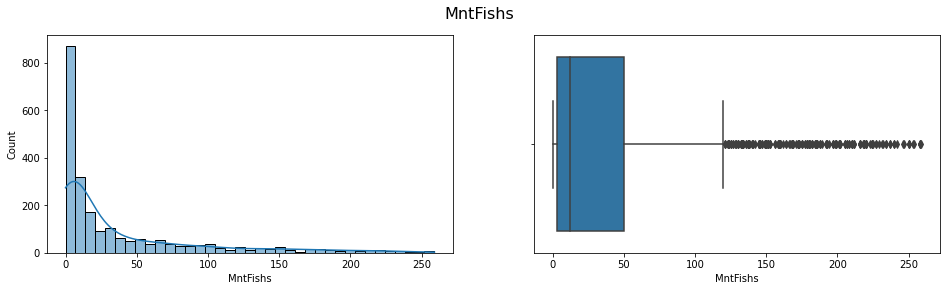

count    2240.000000
mean       37.525446
std        54.628979
min         0.000000
25%         3.000000
50%        12.000000
75%        50.000000
max       259.000000
Name: MntFishs, dtype: float64


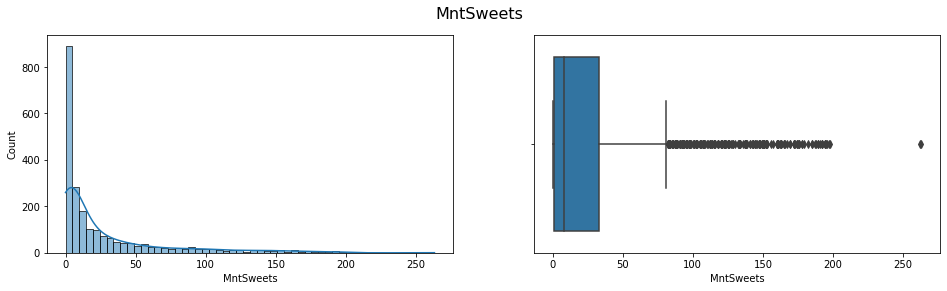

count    2240.000000
mean       27.062946
std        41.280498
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       263.000000
Name: MntSweets, dtype: float64


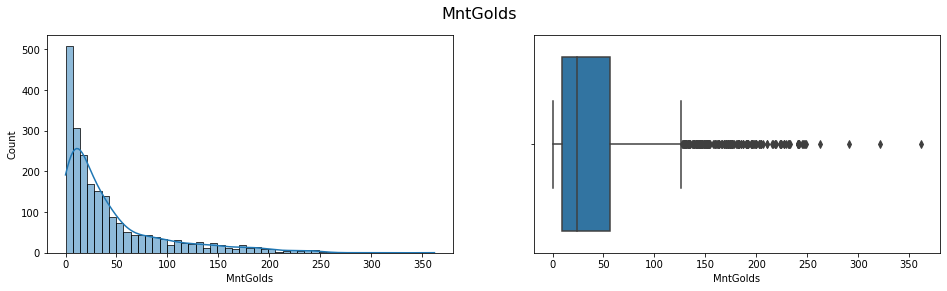

count    2240.000000
mean       44.021875
std        52.167439
min         0.000000
25%         9.000000
50%        24.000000
75%        56.000000
max       362.000000
Name: MntGolds, dtype: float64


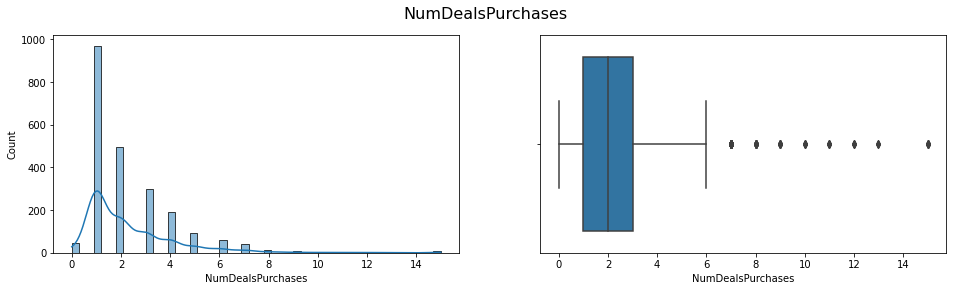

count    2240.000000
mean        2.325000
std         1.932238
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64


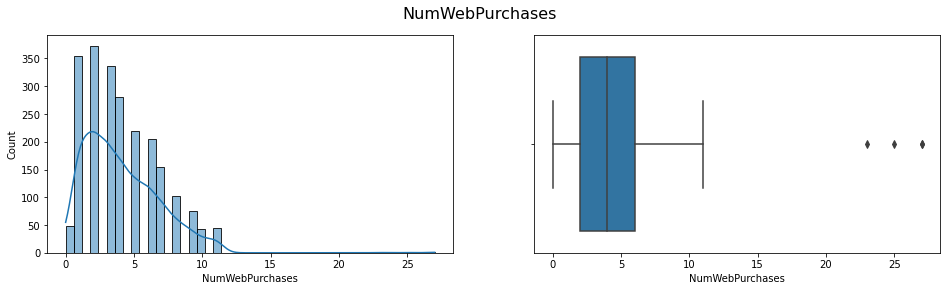

count    2240.000000
mean        4.084821
std         2.778714
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: NumWebPurchases, dtype: float64


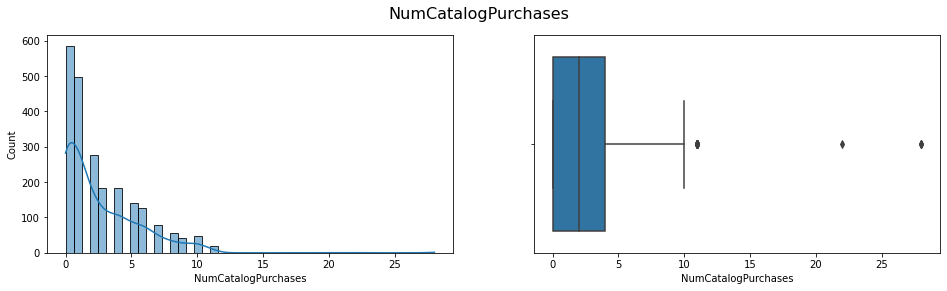

count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        28.000000
Name: NumCatalogPurchases, dtype: float64


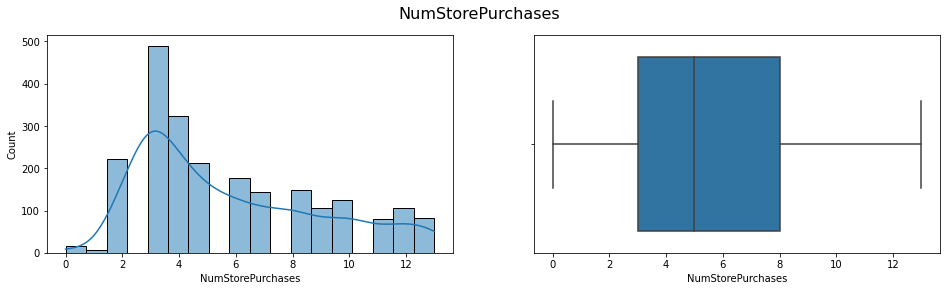

count    2240.000000
mean        5.790179
std         3.250958
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        13.000000
Name: NumStorePurchases, dtype: float64


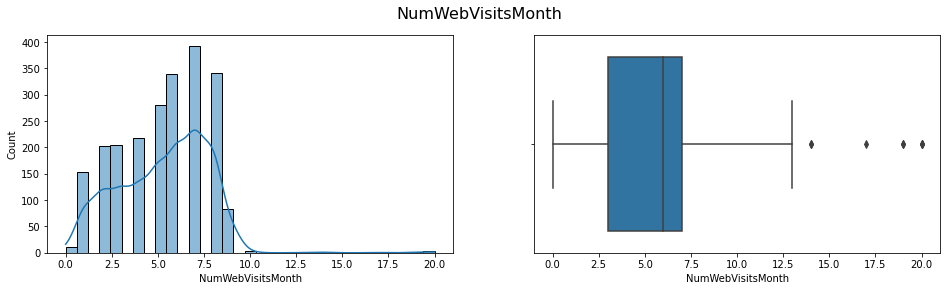

count    2240.000000
mean        5.316518
std         2.426645
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: NumWebVisitsMonth, dtype: float64


In [16]:
for col in numeric.columns:
    if col in ['User_ID', 'Date_Enroll']: continue
    if col == 'AcceptedCmp3': 
      # bắt đầu từ acceptedcmp3 là những dữ liệu dạng binary (0, 1). Ta không cần visualize outliners của những dữ liệu kiểu này
      break
    report(col)

Ta thấy đa phần dữ liệu đều có những outliners nhưng dữ liệu tại cột Year_Birth mang những outliners không đúng logic. Tính tại năm hiện tại (2021) thì những người sinh năm <= 1900 đã vượt ngoài 120 tuổi. Ta tiến hành drop hết những người có độ tuổi là dữ liệu lỗi

In [17]:
# drop những người có độ tuổi trên 100
df = df[numeric['Year_Birth']>1900].reset_index(drop=True)

In [18]:
# Thống kê lại số lượng dữ liệu còn lại
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   User_ID              2237 non-null   int64         
 1   Year_Birth           2237 non-null   int64         
 2   Education            2237 non-null   object        
 3   Marital_Status       2237 non-null   object        
 4   Income               2213 non-null   float64       
 5   Kidhome              2237 non-null   int64         
 6   Teenhome             2237 non-null   int64         
 7   Date_Enroll          2237 non-null   datetime64[ns]
 8   Recency              2237 non-null   int64         
 9   MntWines             2237 non-null   int64         
 10  MntFruits            2237 non-null   int64         
 11  MntMeats             2237 non-null   int64         
 12  MntFishs             2237 non-null   int64         
 13  MntSweets            2237 non-nul